# Taylor Cina D213 Performance Assessment

## Task 1

In [376]:
#Part C4 data preparation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from scipy.signal import periodogram
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


pd.set_option('display.max_columns', None)

csv = pd.read_csv("teleco_time_series.csv", keep_default_na=False, header=0)
print("Initial read:\n", csv.head(5), "\n")

#generate list of dates because converting ["Day"] to datetime gives nanoseconds since 1970
csv.index = pd.date_range(start="20200101", periods=csv["Day"].size, freq='d')
print("Date index:\n", csv)

#compute percent change in revenue
csv["Rev_Diff"] = csv["Revenue"].diff()
csv.dropna(inplace=True)
print("Percent change of revenue:\n", csv)

#Augmented Dickey-Fuller tests
print("Revenue ADF p:", adfuller(csv["Revenue"])[1])
print("Rev_Diff ADF p:", adfuller(csv["Rev_Diff"])[1])

#train test split, 80/20
# 584 train, 146 test
csv_train = csv.iloc[:-147]
csv_test = csv.iloc[-147:]

Initial read:
    Day   Revenue
0    1  0.000000
1    2  0.000793
2    3  0.825542
3    4  0.320332
4    5  1.082554 

Date index:
             Day    Revenue
2020-01-01    1   0.000000
2020-01-02    2   0.000793
2020-01-03    3   0.825542
2020-01-04    4   0.320332
2020-01-05    5   1.082554
...         ...        ...
2021-12-27  727  16.931559
2021-12-28  728  17.490666
2021-12-29  729  16.803638
2021-12-30  730  16.194813
2021-12-31  731  16.620798

[731 rows x 2 columns]
Percent change of revenue:
             Day    Revenue  Rev_Diff
2020-01-02    2   0.000793  0.000793
2020-01-03    3   0.825542  0.824749
2020-01-04    4   0.320332 -0.505210
2020-01-05    5   1.082554  0.762222
2020-01-06    6   0.107654 -0.974900
...         ...        ...       ...
2021-12-27  727  16.931559  0.170280
2021-12-28  728  17.490666  0.559108
2021-12-29  729  16.803638 -0.687028
2021-12-30  730  16.194813 -0.608824
2021-12-31  731  16.620798  0.425985

[730 rows x 3 columns]
Revenue ADF p: 0.3931237

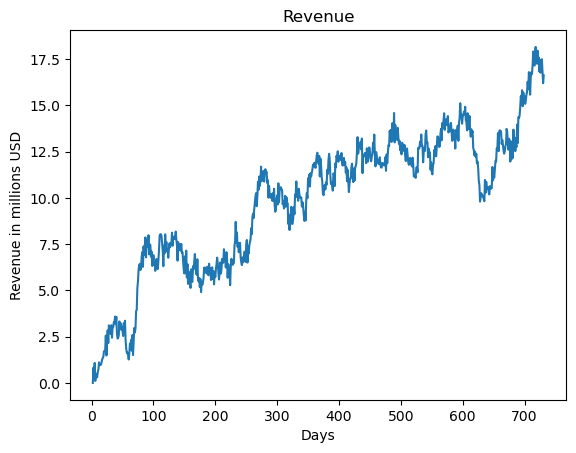

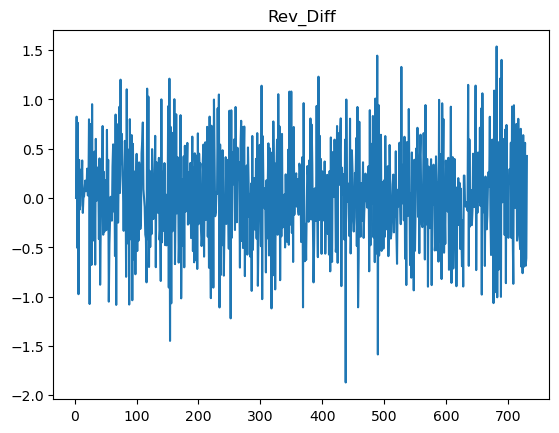

In [377]:
#Part C1 plots

#Plot revenue time series
plt.plot("Day", "Revenue", data=csv)
plt.title("Revenue")
plt.xlabel("Days")
plt.ylabel("Revenue in millions USD")
plt.show()

#plot pct_change revenue
plt.plot("Day", "Rev_Diff", data=csv)
plt.title("Rev_Diff")
plt.show()


In [378]:
#Part C5
csv.to_csv("teleco_time_series_clean.csv")

Lag 1 autocorrelation: -0.4696890672062501


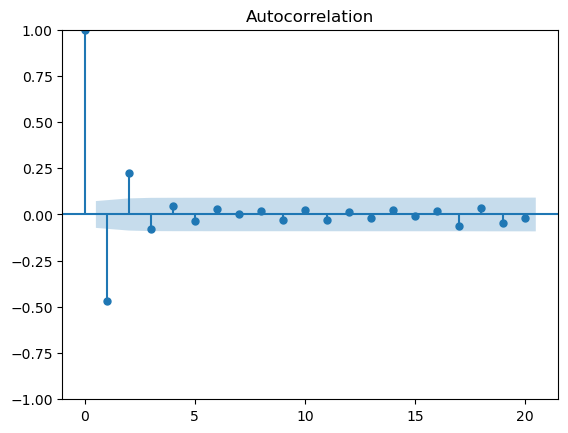

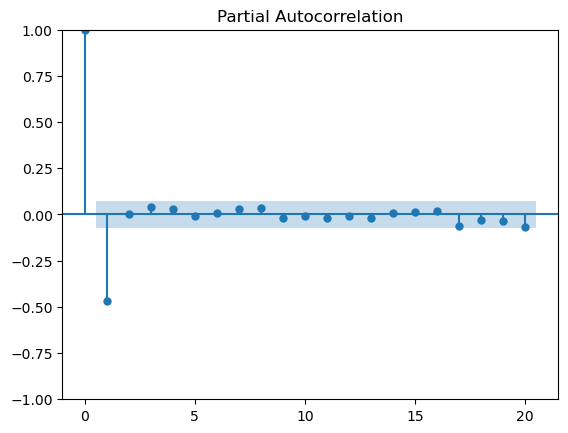

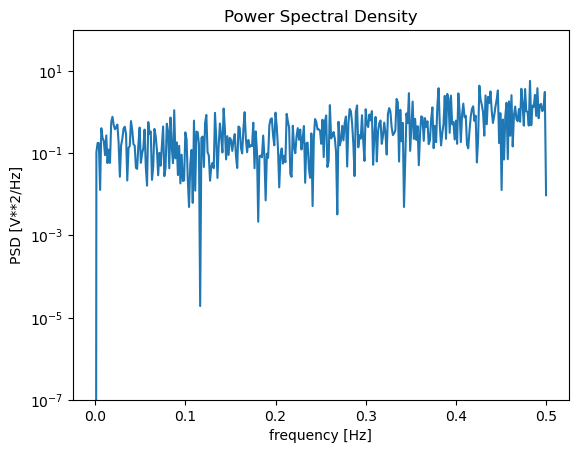

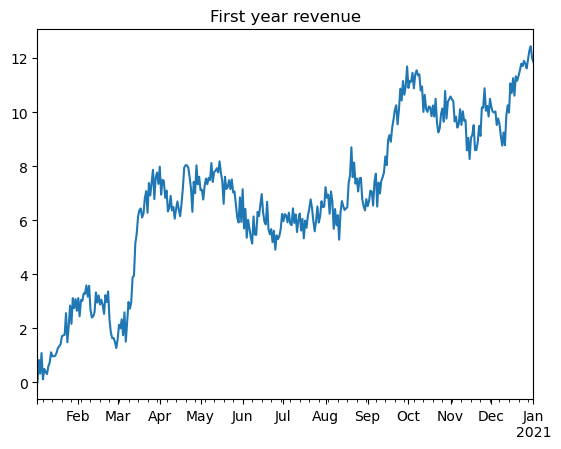

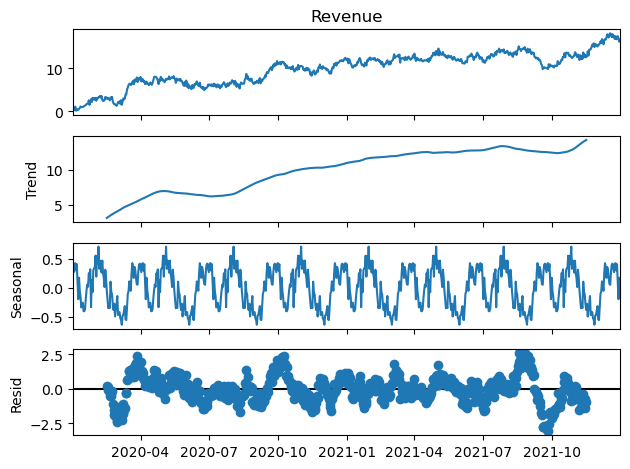

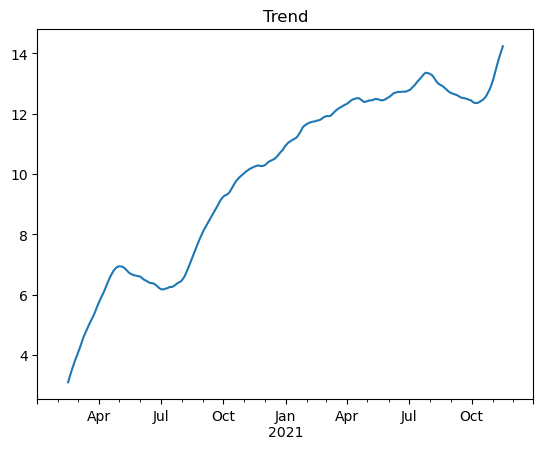

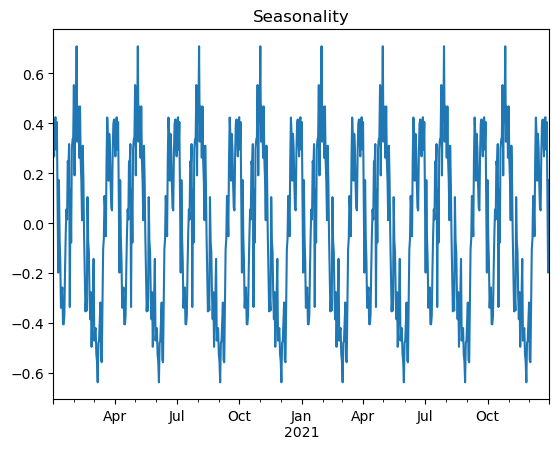

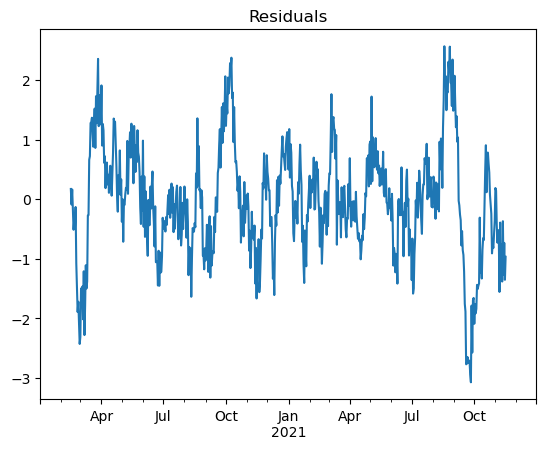

In [379]:
#Part D1

#Autocorrelation plot
print("Lag 1 autocorrelation:", csv["Rev_Diff"].autocorr())
plot_acf(csv["Rev_Diff"], lags=20, alpha=0.05)
plt.title("Autocorrelation")
plt.show()

#partial autocorrelation plot
plot_pacf(csv["Rev_Diff"], lags=20, alpha=0.05)
plt.title("Partial Autocorrelation")
plt.show()

#spectral density plot
f, Pxx_den = periodogram(csv["Rev_Diff"])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title("Power Spectral Density")
plt.show()

#decomposition, seasonality, residuals
csv["Revenue"].loc[:'2021-01-01'].plot()
plt.title("First year revenue")
plt.show()
decomposition = seasonal_decompose(csv["Revenue"], period=90)
decomposition.plot()
plt.show()
decomposition.trend.plot()
plt.title("Trend")
plt.show()
decomposition.seasonal.plot()
plt.title("Seasonality")
plt.show()
decomposition.resid.plot()
plt.title("Residuals")
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                  583
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 90)   Log Likelihood                -426.411
Date:                            Tue, 26 Nov 2024   AIC                            858.823
Time:                                    20:44:05   BIC                            871.418
Sample:                                01-02-2020   HQIC                           863.768
                                     - 08-06-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5134      0.039    -13.151      0.000      -0.590      -0.437
ar.S.L90      -0.4567      0.039   

C:\Users\Mugenri\AppData\Local\Temp\ipykernel_14360\3447327040.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result.plot_diagnostics().show()


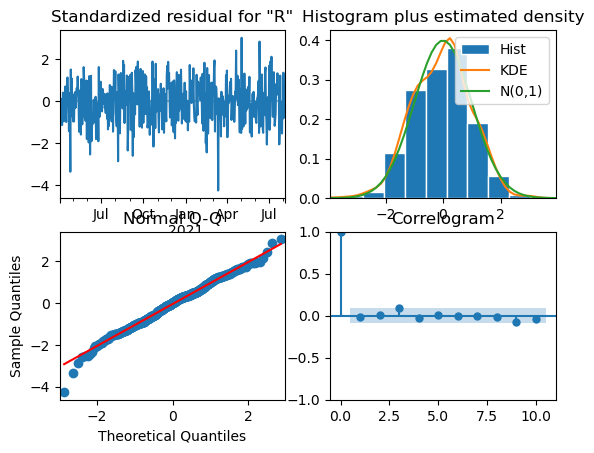

In [380]:
#Part D2 ARIMA model selection on training set
# this takes 9 minutes to run so do it at your own risk
# model = pm.auto_arima(csv_train["Revenue"], seasonal=True, m=90, d=1, D=1, start_p=1, start_q=1, max_p=2, max_q=2, max_P=2, max_Q=2, trace=True, error_action="ignore", suppress_warnings=True)
# print(model.summary())
# #use SARIMAX(1, 1, 0)x(1, 1, 0, 90)
model = SARIMAX(csv_train["Revenue"], order=(1,1,0), seasonal_order=(1,1,0,90))
result = model.fit()
print(result.summary())
result.plot_diagnostics().show()

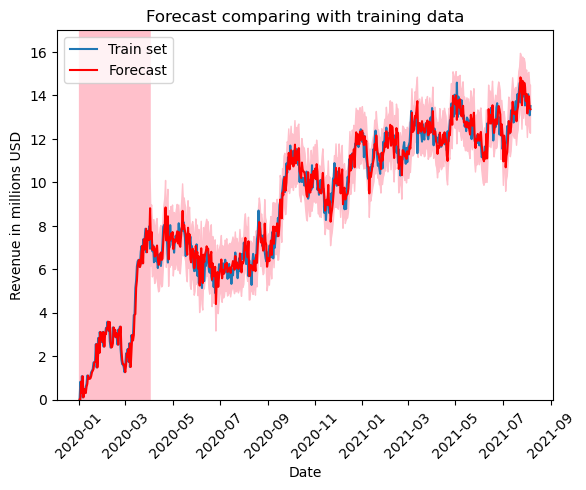

In [381]:
#compare against test data
prediction = result.get_prediction(start=0)
mean_forecast = prediction.predicted_mean
conf_interval = prediction.conf_int()
l_lim = conf_interval.loc[:,"lower Revenue"]
u_lim = conf_interval.loc[:,"upper Revenue"]

#graph
plt.plot(csv_train.index, csv_train["Revenue"], label='Train set')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Forecast')
plt.fill_between(l_lim.index, l_lim, u_lim, color='pink')
plt.title("Forecast comparing with training data")
plt.xlabel("Date")
plt.ylabel("Revenue in millions USD")
plt.ylim(0, 17)
plt.xticks(rotation=45)
plt.legend()
plt.show()

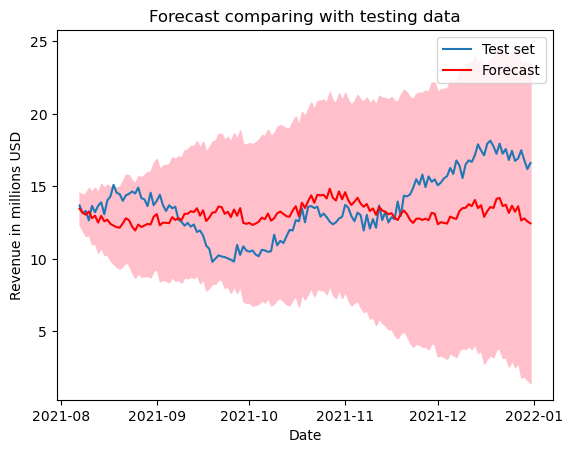

In [382]:
#Part D3 forecast against test data
prediction = result.get_forecast(steps=147)
mean_forecast = prediction.predicted_mean 
conf_interval = prediction.conf_int()
l_lim = conf_interval.loc[:,"lower Revenue"]
u_lim = conf_interval.loc[:,"upper Revenue"]

plt.plot(csv_test.index, csv_test["Revenue"], label='Test set')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Forecast')
plt.fill_between(l_lim.index, l_lim, u_lim, color='pink')
plt.title("Forecast comparing with testing data")
plt.xlabel("Date")
plt.ylabel("Revenue in millions USD")
plt.legend()
plt.show()

In [383]:
#Part E1 model evaluation and error metric
mae = np.mean(np.abs(result.resid))
print("Mean Absolute Error:", mae)
print("AIC:", result.aic)

Mean Absolute Error: 0.4552406246084932
AIC: 858.822630072049


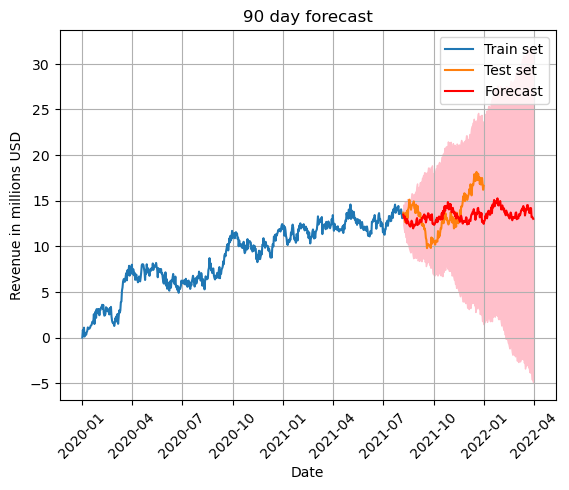

In [384]:
#Part E2 forecast beyond test data
prediction = result.get_forecast(steps=237)
mean_forecast = prediction.predicted_mean 
conf_interval = prediction.conf_int()
l_lim = conf_interval.loc[:,"lower Revenue"]
u_lim = conf_interval.loc[:,"upper Revenue"]

plt.plot(csv_train.index, csv_train["Revenue"], label='Train set')
plt.plot(csv_test.index, csv_test["Revenue"], label='Test set')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Forecast')
plt.fill_between(l_lim.index, l_lim, u_lim, color='pink')
plt.title("90 day forecast")
plt.xlabel("Date")
plt.ylabel("Revenue in millions USD")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()